In [12]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pickle
import random
import pandas as pd

import crunchy_snow.models
import crunchy_snow.dataset

In [3]:
# get paths to data
train_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v3/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v3/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [3]:
# to test code with a small sample of the data

n_imgs = 256

train_path_list = random.sample(train_path_list, n_imgs)
val_path_list = random.sample(val_path_list, n_imgs)

In [4]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
train_data = crunchy_snow.dataset.Dataset(train_path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_data = crunchy_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=16, shuffle=True)

In [5]:
def train_model(input_channels, epochs=10):
    model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
    model.to('cuda');  # Run on GPU
    # Define optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=0.0003)
    loss_fn = nn.MSELoss()
    epochs = epochs
    
    train_loss = []
    val_loss = []
    
    # training and validation loop
    for epoch in range(epochs):
        print(f'\nStarting epoch {epoch+1}')
        epoch_loss = []
        val_temp_loss = []
    
        # Loop through training data with tqdm progress bar
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
        for data_tuple in pbar:
            model.train()
            optimizer.zero_grad()
    
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            epoch_loss.append(loss.item())
    
            # Update tqdm progress bar with batch loss
            pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})
    
    
            loss.backward()  # Propagate the gradients in backward pass
            optimizer.step()
    
        train_loss.append(np.mean(epoch_loss))
        print(f'Training loss: {np.mean(epoch_loss)}')
    
        # Run model on validation data with tqdm progress bar
        for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
            with torch.no_grad():
                model.eval()
                
                # read data into dictionary
                data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
                # prepare inputs by concatenating along channel dimension
                inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
        
                # generate prediction
                pred_sd = model(inputs)
        
                # Limit prediction to areas with valid data
                pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
                aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
        
                # Calculate loss
                loss = loss_fn(pred_sd, aso_sd.to('cuda'))
                val_temp_loss.append(loss.item())
    
        val_loss.append(np.mean(val_temp_loss))
        print(f'Validation loss: {np.mean(val_temp_loss)}')

    return np.min(train_loss), np.min(val_loss)

In [4]:
# define input channels for model
all_input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'snowon_cr',
    'snowoff_cr',
    'delta_cr',
    'blue',
    'green',
    'red',
    'nir',
    'swir1',
    'swir2',
    'scene_class_map',
    'ndvi',
    'ndsi',
    'ndwi',
    'fcf',
    'elevation',
    'latitude',
    'longitude',
    'dowy']

In [ ]:
num_trials = 50
exp_dict = {}
for trial in range(num_trials):
    print('---------------------------------------------------------')
    print(f'trial {trial+1}/{num_trials}')
    input_channels = random.sample(all_input_channels, random.randint(1, len(all_input_channels)))
    print(f'trial {trial+1} input channels: {input_channels}')
    final_train_loss, final_val_loss = train_model(input_channels, epochs=10)
    print(f'trial {trial+1} final train loss: {final_train_loss}, final val loss: {final_val_loss}')
    exp_dict[trial+1] = [input_channels, final_train_loss, final_val_loss]
    # save experiments 
    with open(f'../../loss/ResDepth_feature_sel_loss.pkl', 'wb') as f:
        pickle.dump(exp_dict, f)

---------------------------------------------------------
trial 1/50
trial 0 input channels: ['snowon_vv', 'delta_cr', 'dowy', 'ndvi', 'red', 'snowoff_vv', 'longitude', 'snowon_cr', 'swir1', 'latitude', 'snowon_vh', 'elevation', 'snowoff_cr', 'nir', 'green', 'fcf', 'scene_class_map', 'snowoff_vh', 'ndwi', 'blue', 'ndsi', 'swir2']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00278, mean epoch loss=0.00437]


Training loss: 0.004369288253656123


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0018262272205902264

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000815, mean epoch loss=0.00137]


Training loss: 0.0013694268873223336


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008507830598318833

Starting epoch 3


Epoch 3/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000919, mean epoch loss=0.000996]


Training loss: 0.0009961445848603034


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0008162215563061181

Starting epoch 4


Epoch 4/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000849, mean epoch loss=0.000995]


Training loss: 0.0009950708627002314


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008147438966261689

Starting epoch 5


Epoch 5/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000678, mean epoch loss=0.000946]


Training loss: 0.0009459179746045265


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007947284057081561

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000532, mean epoch loss=0.000938]


Training loss: 0.0009379515231557889


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008178222469723551

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000926, mean epoch loss=0.000934]


Training loss: 0.0009339956995972898


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0007767940151097719

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00149, mean epoch loss=0.000907]


Training loss: 0.0009067668688658159


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0007642054279131116

Starting epoch 9


Epoch 9/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.000564, mean epoch loss=0.000938]


Training loss: 0.0009383510277984897


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008118522364384262

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00168, mean epoch loss=0.000908]


Training loss: 0.0009077580289158504


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007839992103981785
trial 0 final train loss: 0.0009077580289158504, final val loss: 0.0007839992103981785
---------------------------------------------------------
trial 2/50
trial 1 input channels: ['snowoff_vh', 'snowon_cr', 'ndsi', 'scene_class_map', 'snowoff_cr', 'swir1', 'snowon_vv', 'longitude', 'ndwi', 'fcf', 'nir']

Starting epoch 1


Epoch 1/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000689, mean epoch loss=0.00153]


Training loss: 0.0015290322371583898


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0010297227017872501

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00051, mean epoch loss=0.00103]


Training loss: 0.0010348560444981558


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0009388424696226139

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00129, mean epoch loss=0.00106]


Training loss: 0.001059607067873003


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.000983318233920727

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000922, mean epoch loss=0.00115]


Training loss: 0.0011474039383756462


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007653271932213102

Starting epoch 5


Epoch 5/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000469, mean epoch loss=0.000934]


Training loss: 0.0009339548814750742


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.04s/batch]


Validation loss: 0.0007900753280409845

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.05s/batch, batch loss=0.000971, mean epoch loss=0.000893]


Training loss: 0.0008930007243179716


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.04s/batch]


Validation loss: 0.0007779747029417194

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.04s/batch, batch loss=0.000678, mean epoch loss=0.000877]


Training loss: 0.0008768691404839046


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.04s/batch]


Validation loss: 0.0007198477833298966

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00055, mean epoch loss=0.000904]


Training loss: 0.0009035679286171217


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0007219625513243955

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00158, mean epoch loss=0.000927]


Training loss: 0.0009269568890886148


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007288298083949485

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:16<00:00,  1.04s/batch, batch loss=0.000951, mean epoch loss=0.000984]


Training loss: 0.0009836301032919437


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007507818281737855
trial 1 final train loss: 0.0009836301032919437, final val loss: 0.0007507818281737855
---------------------------------------------------------
trial 3/50
trial 2 input channels: ['ndvi', 'elevation', 'snowoff_vh', 'snowoff_cr', 'scene_class_map', 'latitude', 'swir1', 'green', 'snowon_vv', 'nir', 'blue', 'longitude', 'snowon_vh', 'delta_cr', 'swir2']

Starting epoch 1


Epoch 1/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000662, mean epoch loss=0.00164]


Training loss: 0.0016442562009615358


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007965446638991125

Starting epoch 2


Epoch 2/10: 100%|███████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00134, mean epoch loss=0.001]


Training loss: 0.0010000261499953922


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0009324637285317294

Starting epoch 3


Epoch 3/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000423, mean epoch loss=0.00103]


Training loss: 0.001025245908749639


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008657646358187776

Starting epoch 4


Epoch 4/10: 100%|███████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00084, mean epoch loss=0.001]


Training loss: 0.001002497891022358


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007802594263921492

Starting epoch 5


Epoch 5/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000648, mean epoch loss=0.000886]


Training loss: 0.0008860606840244145


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007409340541926213

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000409, mean epoch loss=0.000863]


Training loss: 0.0008627451770735206


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0009000577119877562

Starting epoch 7


Epoch 7/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.0012, mean epoch loss=0.000986]


Training loss: 0.0009864810763247078


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008396673110837582

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000716, mean epoch loss=0.000902]


Training loss: 0.0009018217260745587


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007647786496818298

Starting epoch 9


Epoch 9/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000247, mean epoch loss=0.000878]


Training loss: 0.000878331222338602


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007447145590049331

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00154, mean epoch loss=0.000869]


Training loss: 0.000868940279360686


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007828228663129266
trial 2 final train loss: 0.000868940279360686, final val loss: 0.0007828228663129266
---------------------------------------------------------
trial 4/50
trial 3 input channels: ['ndwi', 'snowoff_cr', 'ndsi', 'ndvi', 'red', 'scene_class_map', 'fcf', 'dowy', 'swir1', 'snowoff_vv', 'nir', 'longitude', 'delta_cr', 'snowon_cr', 'green', 'swir2', 'latitude']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00096, mean epoch loss=0.00177]


Training loss: 0.001774872205714928


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0009569701414875453

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000457, mean epoch loss=0.00115]


Training loss: 0.0011455426320026163


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.001035450681229122

Starting epoch 3


Epoch 3/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000311, mean epoch loss=0.00101]


Training loss: 0.0010136843829968711


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008846310629451182

Starting epoch 4


Epoch 4/10: 100%|███████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00201, mean epoch loss=0.001]


Training loss: 0.001000505162664922


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0009453458187635988

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00103, mean epoch loss=0.000991]


Training loss: 0.0009906326267810073


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008423789768130518

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.04s/batch, batch loss=0.000418, mean epoch loss=0.000959]


Training loss: 0.0009590376957930857


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008054310337684001

Starting epoch 7


Epoch 7/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000985, mean epoch loss=0.00102]


Training loss: 0.0010188256310357247


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007987149747350486

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000481, mean epoch loss=0.000946]


Training loss: 0.0009455804829485714


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008800404084468028

Starting epoch 9


Epoch 9/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.000422, mean epoch loss=0.000939]


Training loss: 0.0009394877633894794


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007942851088955649

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00113, mean epoch loss=0.000983]


Training loss: 0.0009832567084231414


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0008553938569093589
trial 3 final train loss: 0.0009832567084231414, final val loss: 0.0008553938569093589
---------------------------------------------------------
trial 5/50
trial 4 input channels: ['snowon_vh', 'ndsi', 'elevation', 'latitude', 'snowoff_cr', 'swir2', 'longitude', 'scene_class_map', 'ndwi', 'dowy', 'snowon_vv', 'red', 'fcf', 'swir1', 'snowon_cr', 'snowoff_vh']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00166, mean epoch loss=0.00242]


Training loss: 0.0024222450956585817


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008951242489274591

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000986, mean epoch loss=0.00118]


Training loss: 0.0011836597077490296


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0008369245642825263

Starting epoch 3


Epoch 3/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.000668, mean epoch loss=0.000985]


Training loss: 0.0009846812135947403


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008062887782216421

Starting epoch 4


Epoch 4/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.0012, mean epoch loss=0.000945]


Training loss: 0.0009449688641325338


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008320685356011381

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00103, mean epoch loss=0.000921]


Training loss: 0.0009212922595907003


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007861096983106108

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000951, mean epoch loss=0.000916]


Training loss: 0.0009162962123809848


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0009057294919330161

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000588, mean epoch loss=0.000872]


Training loss: 0.000872214784976677


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007775135363772279

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00253, mean epoch loss=0.000925]


Training loss: 0.0009253627395082731


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007604755064676283

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000677, mean epoch loss=0.00097]


Training loss: 0.0009700883510959102


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.00084817729293718

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00095, mean epoch loss=0.000877]


Training loss: 0.0008771716347837355


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007401761922665173
trial 4 final train loss: 0.0008771716347837355, final val loss: 0.0007401761922665173
---------------------------------------------------------
trial 6/50
trial 5 input channels: ['nir', 'ndwi', 'red', 'delta_cr', 'swir2', 'swir1', 'snowon_cr', 'dowy', 'ndvi', 'snowon_vv', 'green', 'fcf', 'longitude', 'blue']

Starting epoch 1


Epoch 1/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000428, mean epoch loss=0.00183]


Training loss: 0.0018267880568600958


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0010217085327894893

Starting epoch 2


Epoch 2/10: 100%|██████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.0014, mean epoch loss=0.00101]


Training loss: 0.0010103938566317083


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008601794925198192

Starting epoch 3


Epoch 3/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000652, mean epoch loss=0.00102]


Training loss: 0.0010178855300182477


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008451034427707782

Starting epoch 4


Epoch 4/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000599, mean epoch loss=0.0009]


Training loss: 0.0008998682078527054


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007881366527726641

Starting epoch 5


Epoch 5/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000819, mean epoch loss=0.000951]


Training loss: 0.0009512454016658012


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.000853535981150344

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000708, mean epoch loss=0.000994]


Training loss: 0.0009940174386429135


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008318555310324882

Starting epoch 7


Epoch 7/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000597, mean epoch loss=0.00088]


Training loss: 0.0008804391982266679


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007672174760955386

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00137, mean epoch loss=0.000872]


Training loss: 0.0008715181429579388


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007446693516612868

Starting epoch 9


Epoch 9/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.000906, mean epoch loss=0.000829]


Training loss: 0.0008293513583339518


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007211604624899337

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000784, mean epoch loss=0.00081]


Training loss: 0.0008096641940937843


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007677382081965334
trial 5 final train loss: 0.0008096641940937843, final val loss: 0.0007677382081965334
---------------------------------------------------------
trial 7/50
trial 6 input channels: ['dowy', 'scene_class_map', 'nir', 'snowon_cr', 'snowon_vh', 'green', 'delta_cr', 'red', 'swir2', 'snowon_vv', 'latitude', 'snowoff_vv', 'elevation']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00169, mean epoch loss=0.00165]


Training loss: 0.001654265506658703


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0011697916270350106

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.000862, mean epoch loss=0.00103]


Training loss: 0.001026596950396197


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008154878451023251

Starting epoch 3


Epoch 3/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000686, mean epoch loss=0.000943]


Training loss: 0.0009431274738744833


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008705581531103235

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00137, mean epoch loss=0.000938]


Training loss: 0.0009383422348037129


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007765347418171586

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000624, mean epoch loss=0.00101]


Training loss: 0.0010056744304165477


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008390908187720925

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000617, mean epoch loss=0.000959]


Training loss: 0.0009590942026989069


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008061207645368995

Starting epoch 7


Epoch 7/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00129, mean epoch loss=0.000964]


Training loss: 0.0009637587827455718


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007408327855955577

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000687, mean epoch loss=0.000931]


Training loss: 0.0009309900242442382


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0009624987505958416

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000486, mean epoch loss=0.00101]


Training loss: 0.0010063504996651318


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007652055064681917

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000606, mean epoch loss=0.000888]


Training loss: 0.0008882377169356914


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007319245269172825
trial 6 final train loss: 0.0008882377169356914, final val loss: 0.0007319245269172825
---------------------------------------------------------
trial 8/50
trial 7 input channels: ['latitude', 'ndsi', 'longitude', 'snowon_cr', 'green', 'blue', 'snowoff_vh', 'ndvi', 'delta_cr']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00202, mean epoch loss=0.00387]


Training loss: 0.003869621461490169


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.001996995728404727

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000544, mean epoch loss=0.00148]


Training loss: 0.0014813322595728096


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0010146683180209948

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00111, mean epoch loss=0.00114]


Training loss: 0.001136038474214729


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008576155305490829

Starting epoch 4


Epoch 4/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000765, mean epoch loss=0.000985]


Training loss: 0.000985212598607177


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008221680946007837

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00116, mean epoch loss=0.000984]


Training loss: 0.0009843318493949482


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008128857643896481

Starting epoch 6


Epoch 6/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00204, mean epoch loss=0.000971]


Training loss: 0.0009708618090371601


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008054558747971896

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000919, mean epoch loss=0.000995]


Training loss: 0.0009946764002961572


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0009220276715495856

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000627, mean epoch loss=0.00105]


Training loss: 0.0010536004665482324


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008701786264282418

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00103, mean epoch loss=0.000969]


Training loss: 0.0009691979103081394


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0007984921576280612

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000372, mean epoch loss=0.000937]


Training loss: 0.0009372924023409723


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008148217584675876
trial 7 final train loss: 0.0009372924023409723, final val loss: 0.0008148217584675876
---------------------------------------------------------
trial 9/50
trial 8 input channels: ['snowoff_vh', 'snowon_vv', 'latitude', 'snowoff_cr', 'delta_cr', 'swir2', 'red', 'snowoff_vv', 'ndvi', 'nir', 'dowy', 'ndwi', 'ndsi', 'swir1', 'elevation', 'blue', 'green']

Starting epoch 1


Epoch 1/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000917, mean epoch loss=0.00276]


Training loss: 0.002756098831014242


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008883842965587974

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00117, mean epoch loss=0.00111]


Training loss: 0.0011072460183640942


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.000868532495587715

Starting epoch 3


Epoch 3/10: 100%|███████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00086, mean epoch loss=0.001]


Training loss: 0.0010042283647635486


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0008723046703380533

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00089, mean epoch loss=0.000956]


Training loss: 0.0009560074704495491


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0009944072844518814

Starting epoch 5


Epoch 5/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000816, mean epoch loss=0.000987]


Training loss: 0.0009871323163679335


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0009069367915799376

Starting epoch 6


Epoch 6/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00147, mean epoch loss=0.000959]


Training loss: 0.0009589456603862345


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0009138590867223684

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.000786, mean epoch loss=0.000903]


Training loss: 0.0009029263928823639


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0007747865474811988

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00106, mean epoch loss=0.000869]


Training loss: 0.0008690487984495121


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0007386714351014234

Starting epoch 9


Epoch 9/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000303, mean epoch loss=0.000858]


Training loss: 0.0008584727875131648


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007381269588222494

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000348, mean epoch loss=0.000839]


Training loss: 0.0008386978624912445


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0007232928819576045
trial 8 final train loss: 0.0008386978624912445, final val loss: 0.0007232928819576045
---------------------------------------------------------
trial 10/50
trial 9 input channels: ['snowoff_cr', 'fcf', 'snowoff_vh', 'ndvi', 'swir1', 'delta_cr', 'scene_class_map', 'red', 'snowon_vh', 'nir', 'latitude', 'ndwi', 'snowoff_vv', 'dowy', 'longitude']

Starting epoch 1


Epoch 1/10: 100%|██████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00684, mean epoch loss=0.0129]


Training loss: 0.012918349573737942


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.004005861599580385

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.000598, mean epoch loss=0.0026]


Training loss: 0.0026001935548265465


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0012526015634648502

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.04s/batch, batch loss=0.00101, mean epoch loss=0.00128]


Training loss: 0.0012813517132599372


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0010645768124959432

Starting epoch 4


Epoch 4/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00057, mean epoch loss=0.00111]


Training loss: 0.001112104240746703


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.001032390884574852

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000654, mean epoch loss=0.00102]


Training loss: 0.0010203465535596479


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0009417500532435952

Starting epoch 6


Epoch 6/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00121, mean epoch loss=0.00101]


Training loss: 0.0010105465116794221


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.000904481526958989

Starting epoch 7


Epoch 7/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00059, mean epoch loss=0.00101]


Training loss: 0.0010086583497468382


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0010038570071628783

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00147, mean epoch loss=0.000978]


Training loss: 0.0009784563590073958


Validation: 100%|██████████| 16/16 [00:17<00:00,  1.10s/batch]


Validation loss: 0.0009672739724919666

Starting epoch 9


Epoch 9/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000357, mean epoch loss=0.000985]


Training loss: 0.0009852745970420074


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.00091532203987299

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000781, mean epoch loss=0.00103]


Training loss: 0.0010324945251340978


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008360096053365851
trial 9 final train loss: 0.0010324945251340978, final val loss: 0.0008360096053365851
---------------------------------------------------------
trial 11/50
trial 10 input channels: ['snowoff_vh', 'swir1', 'green']

Starting epoch 1


Epoch 1/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000279, mean epoch loss=0.00133]


Training loss: 0.0013288636564539047


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008828766976876068

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.000919, mean epoch loss=0.00101]


Training loss: 0.0010120613533217693


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007304765440494521

Starting epoch 3


Epoch 3/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000609, mean epoch loss=0.000927]


Training loss: 0.0009274378244299442


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0007211709917100961

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00116, mean epoch loss=0.000884]


Training loss: 0.0008844187432259787


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.000705919290339807

Starting epoch 5


Epoch 5/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000655, mean epoch loss=0.000869]


Training loss: 0.0008690540271345526


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0006890166241646511

Starting epoch 6


Epoch 6/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000963, mean epoch loss=0.00089]


Training loss: 0.0008895321952877566


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007324587868424715

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000665, mean epoch loss=0.000832]


Training loss: 0.000832364552479703


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0006834843052274664

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00069, mean epoch loss=0.000877]


Training loss: 0.000877122865858837


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.00073588160557847

Starting epoch 9


Epoch 9/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000747, mean epoch loss=0.000872]


Training loss: 0.0008715029234735994


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0006713813454553019

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00083, mean epoch loss=0.000828]


Training loss: 0.0008283821298391558


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0006724965396642801
trial 10 final train loss: 0.0008283821298391558, final val loss: 0.0006724965396642801
---------------------------------------------------------
trial 12/50
trial 11 input channels: ['latitude', 'snowoff_vv', 'fcf', 'snowon_vv', 'scene_class_map', 'longitude', 'ndvi', 'swir1', 'dowy']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00168, mean epoch loss=0.00617]


Training loss: 0.0061742636826238595


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0014653821162937675

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000912, mean epoch loss=0.00161]


Training loss: 0.00161482682415226


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0012692634118138812

Starting epoch 3


Epoch 3/10: 100%|██████████████████████████████████| 16/16 [00:16<00:00,  1.04s/batch, batch loss=0.00201, mean epoch loss=0.0012]


Training loss: 0.0012007253026240505


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0011712848445313284

Starting epoch 4


Epoch 4/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00177, mean epoch loss=0.00116]


Training loss: 0.0011568100089789368


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0010703564803407062

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000991, mean epoch loss=0.00116]


Training loss: 0.0011595174692047294


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0010436442844365956

Starting epoch 6


Epoch 6/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00123, mean epoch loss=0.00108]


Training loss: 0.0010778881587611977


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0010105768633366097

Starting epoch 7


Epoch 7/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000798, mean epoch loss=0.00105]


Training loss: 0.001051382167133852


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0010516193524381379

Starting epoch 8


Epoch 8/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00123, mean epoch loss=0.00103]


Training loss: 0.00103476347430842


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0009709656951599754

Starting epoch 9


Epoch 9/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00124, mean epoch loss=0.00101]


Training loss: 0.0010118626269104425


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.000973050336142478

Starting epoch 10


Epoch 10/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00221, mean epoch loss=0.00105]


Training loss: 0.0010464285714988364


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0009562407276462181
trial 11 final train loss: 0.0010464285714988364, final val loss: 0.0009562407276462181
---------------------------------------------------------
trial 13/50
trial 12 input channels: ['snowoff_vv', 'elevation', 'delta_cr', 'dowy', 'snowoff_vh', 'snowon_vv', 'snowon_vh', 'snowon_cr', 'longitude', 'fcf', 'swir1', 'ndwi', 'snowoff_cr', 'scene_class_map', 'ndvi', 'swir2']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00198, mean epoch loss=0.00162]


Training loss: 0.0016177966135728639


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0012305707696214085

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000816, mean epoch loss=0.00119]


Training loss: 0.001185172621262609


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.001061765167833073

Starting epoch 3


Epoch 3/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000873, mean epoch loss=0.00107]


Training loss: 0.0010675364792405162


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0009895473158394452

Starting epoch 4


Epoch 4/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00077, mean epoch loss=0.00102]


Training loss: 0.0010174186154472409


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0009692541461845394

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000552, mean epoch loss=0.00101]


Training loss: 0.0010054238482553046


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0009686521170806373

Starting epoch 6


Epoch 6/10: 100%|████████████████████████████████| 16/16 [00:17<00:00,  1.07s/batch, batch loss=0.000549, mean epoch loss=0.00101]


Training loss: 0.0010067732764582615


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.04s/batch]


Validation loss: 0.000918389814614784

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████████| 16/16 [00:16<00:00,  1.06s/batch, batch loss=0.00117, mean epoch loss=0.001]


Training loss: 0.0010028676788351731


Validation: 100%|██████████| 16/16 [00:17<00:00,  1.10s/batch]


Validation loss: 0.0009324872571596643

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████████| 16/16 [00:16<00:00,  1.05s/batch, batch loss=0.00116, mean epoch loss=0.001]


Training loss: 0.0010048071690107463


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.001138683332101209

Starting epoch 9


Epoch 9/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00113, mean epoch loss=0.00115]


Training loss: 0.001151604459664668


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0010120565439137863

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.000546, mean epoch loss=0.00102]


Training loss: 0.0010153058028663509


Validation: 100%|██████████| 16/16 [00:17<00:00,  1.07s/batch]


Validation loss: 0.0008912017547118012
trial 12 final train loss: 0.0010153058028663509, final val loss: 0.0008912017547118012
---------------------------------------------------------
trial 14/50
trial 13 input channels: ['dowy', 'snowon_vh', 'ndsi', 'snowon_cr', 'snowoff_cr', 'snowoff_vv', 'longitude']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.05s/batch, batch loss=0.00133, mean epoch loss=0.00386]


Training loss: 0.0038624737189820735


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0015082697354955599

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000493, mean epoch loss=0.00123]


Training loss: 0.0012326711530477041


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008832696694298647

Starting epoch 3


Epoch 3/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000809, mean epoch loss=0.000969]


Training loss: 0.0009686543089628685


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008838825433485908

Starting epoch 4


Epoch 4/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000447, mean epoch loss=0.000959]


Training loss: 0.0009587774256942794


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0009477349776716437

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00112, mean epoch loss=0.000945]


Training loss: 0.0009453630827920279


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0009004189505503746

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000979, mean epoch loss=0.000939]


Training loss: 0.00093878136613057


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008574654020776507

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000795, mean epoch loss=0.000939]


Training loss: 0.0009388906619278714


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008484876175316458

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000646, mean epoch loss=0.000931]


Training loss: 0.0009307146356150042


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008482022094540298

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00125, mean epoch loss=0.000985]


Training loss: 0.00098506257563713


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0010115541317645693

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00273, mean epoch loss=0.000989]


Training loss: 0.0009889822104014456


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0008723520368221216
trial 13 final train loss: 0.0009889822104014456, final val loss: 0.0008723520368221216
---------------------------------------------------------
trial 15/50
trial 14 input channels: ['snowon_vv', 'elevation', 'snowoff_vv', 'ndwi', 'latitude', 'snowoff_cr', 'delta_cr', 'swir1', 'snowon_cr', 'scene_class_map', 'green', 'fcf', 'snowon_vh', 'blue', 'ndsi', 'red']

Starting epoch 1


Epoch 1/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.000751, mean epoch loss=0.00137]


Training loss: 0.0013697459544346202


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0010359420666645747

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00195, mean epoch loss=0.00109]


Training loss: 0.0010916644278040621


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008807852173049469

Starting epoch 3


Epoch 3/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000616, mean epoch loss=0.000951]


Training loss: 0.0009514453740848694


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/batch]


Validation loss: 0.0007957640718814218

Starting epoch 4


Epoch 4/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000409, mean epoch loss=0.000902]


Training loss: 0.000902432964721811


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007897204277469427

Starting epoch 5


Epoch 5/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00073, mean epoch loss=0.00103]


Training loss: 0.0010280395490553929


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007946506157168187

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000507, mean epoch loss=0.000888]


Training loss: 0.0008882883084879722


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.000768446096117259

Starting epoch 7


Epoch 7/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00137, mean epoch loss=0.000884]


Training loss: 0.0008838730464049149


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0007695541589782806

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000423, mean epoch loss=0.000878]


Training loss: 0.0008775261067057727


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007417718534270534

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00175, mean epoch loss=0.000977]


Training loss: 0.000976955181613448


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.000825368721052655

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000573, mean epoch loss=0.000991]


Training loss: 0.000990619571894058


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007091600673447829
trial 14 final train loss: 0.000990619571894058, final val loss: 0.0007091600673447829
---------------------------------------------------------
trial 16/50
trial 15 input channels: ['snowoff_vh']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00132, mean epoch loss=0.00442]


Training loss: 0.004418643093231367


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0017675674753263593

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00381, mean epoch loss=0.00169]


Training loss: 0.0016928317872952903


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0014108787436271086

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00177, mean epoch loss=0.00162]


Training loss: 0.0016193266565096565


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0013964671816211194

Starting epoch 4


Epoch 4/10: 100%|██████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.0012, mean epoch loss=0.00159]


Training loss: 0.0015875941280683037


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0015290149131033104

Starting epoch 5


Epoch 5/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00086, mean epoch loss=0.00155]


Training loss: 0.0015507079879171215


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.00134616598370485

Starting epoch 6


Epoch 6/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.00181, mean epoch loss=0.00156]


Training loss: 0.0015628074324922636


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0013405101199168712

Starting epoch 7


Epoch 7/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00102, mean epoch loss=0.00158]


Training loss: 0.0015790150901011657


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0013376351453189272

Starting epoch 8


Epoch 8/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00219, mean epoch loss=0.00157]


Training loss: 0.0015677665869588964


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0013459244273690274

Starting epoch 9


Epoch 9/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000753, mean epoch loss=0.0016]


Training loss: 0.0015983710582077038


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0014377051029441645

Starting epoch 10


Epoch 10/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00165, mean epoch loss=0.00179]


Training loss: 0.001786409891792573


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0013909258577768924
trial 15 final train loss: 0.001786409891792573, final val loss: 0.0013909258577768924
---------------------------------------------------------
trial 17/50
trial 16 input channels: ['ndvi', 'snowon_cr', 'swir1', 'red', 'snowon_vv', 'snowoff_cr', 'longitude', 'latitude', 'scene_class_map', 'elevation', 'delta_cr', 'blue', 'swir2']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00252, mean epoch loss=0.00248]


Training loss: 0.0024827959241520148


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0013058614786132239

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000673, mean epoch loss=0.00113]


Training loss: 0.001131574406826985


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007863790724513819

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.03s/batch, batch loss=0.00149, mean epoch loss=0.00095]


Training loss: 0.0009498775343672605


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0007624659174325643

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00211, mean epoch loss=0.000932]


Training loss: 0.0009321955694758799


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.000769094795032288

Starting epoch 5


Epoch 5/10: 100%|███████████████████████████████| 16/16 [00:22<00:00,  1.38s/batch, batch loss=0.000709, mean epoch loss=0.000936]


Training loss: 0.0009355447364214342


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.06s/batch]


Validation loss: 0.0007337392398767406

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000653, mean epoch loss=0.000925]


Training loss: 0.000924725358345313


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007211592073872453

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.000344, mean epoch loss=0.000881]


Training loss: 0.0008808795837467187


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0007624687204952352

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00102, mean epoch loss=0.000982]


Training loss: 0.0009823905056691729


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0008778585543041117

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.02s/batch, batch loss=0.00108, mean epoch loss=0.000925]


Training loss: 0.0009245964865840506


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007708343255217187

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000723, mean epoch loss=0.000998]


Training loss: 0.0009979081114579458


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.000716126627594349
trial 16 final train loss: 0.0009979081114579458, final val loss: 0.000716126627594349
---------------------------------------------------------
trial 18/50
trial 17 input channels: ['ndsi', 'green', 'ndwi', 'latitude', 'scene_class_map', 'snowon_vv', 'red', 'snowoff_vh', 'snowon_vh', 'ndvi', 'swir2', 'delta_cr', 'snowoff_cr', 'longitude', 'snowoff_vv']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.00147, mean epoch loss=0.00348]


Training loss: 0.003482569496554788


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.02s/batch]


Validation loss: 0.0011998217887594365

Starting epoch 2


Epoch 2/10: 100%|██████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00101, mean epoch loss=0.0014]


Training loss: 0.0013985457117087208


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008930703879741486

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00025, mean epoch loss=0.00107]


Training loss: 0.001068234241756727


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008558852241549175

Starting epoch 4


Epoch 4/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.00052, mean epoch loss=0.00105]


Training loss: 0.0010462632053531706


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008172765556082595

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000504, mean epoch loss=0.00102]


Training loss: 0.0010172899019380566


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0009546553119434975

Starting epoch 6


Epoch 6/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.00104, mean epoch loss=0.000971]


Training loss: 0.0009711479942779988


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0007894863701949362

Starting epoch 7


Epoch 7/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000525, mean epoch loss=0.00111]


Training loss: 0.001111840618250426


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008380368890357204

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000954, mean epoch loss=0.000955]


Training loss: 0.0009554658718116116


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008008199802134186

Starting epoch 9


Epoch 9/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000951, mean epoch loss=0.000948]


Training loss: 0.0009475103033764753


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0007689096528338268

Starting epoch 10


Epoch 10/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.0011, mean epoch loss=0.000942]


Training loss: 0.0009423408710063086


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0007622654011356644
trial 17 final train loss: 0.0009423408710063086, final val loss: 0.0007622654011356644
---------------------------------------------------------
trial 19/50
trial 18 input channels: ['snowoff_vv', 'fcf', 'longitude', 'dowy', 'red', 'ndwi', 'snowon_vh', 'snowoff_vh', 'snowon_cr', 'ndsi', 'nir', 'blue']

Starting epoch 1


Epoch 1/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000975, mean epoch loss=0.00239]


Training loss: 0.002385915933700744


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0011628732027020305

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00155, mean epoch loss=0.00116]


Training loss: 0.0011618042626651004


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0009042238289111992

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00117, mean epoch loss=0.00101]


Training loss: 0.0010066955001093447


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.000847704474836064

Starting epoch 4


Epoch 4/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000551, mean epoch loss=0.000964]


Training loss: 0.0009638289538997924


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008391474448217195

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00121, mean epoch loss=0.000984]


Training loss: 0.000984108275588369


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008551586242901976

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000547, mean epoch loss=0.000961]


Training loss: 0.0009612113753973972


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008187661096599186

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000386, mean epoch loss=0.000941]


Training loss: 0.0009406360477441922


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0008949220191425411

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000476, mean epoch loss=0.000943]


Training loss: 0.0009433970408281311


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008155183641065378

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000156, mean epoch loss=0.00096]


Training loss: 0.000959927147050621


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008010789179024869

Starting epoch 10


Epoch 10/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00046, mean epoch loss=0.0009]


Training loss: 0.0009003015275084181


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0007891476234362926
trial 18 final train loss: 0.0009003015275084181, final val loss: 0.0007891476234362926
---------------------------------------------------------
trial 20/50
trial 19 input channels: ['ndsi', 'swir2', 'longitude', 'snowoff_cr', 'snowon_cr', 'elevation', 'ndwi', 'latitude', 'snowon_vv', 'scene_class_map']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00121, mean epoch loss=0.00178]


Training loss: 0.0017772511200746521


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0010042716439784272

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00157, mean epoch loss=0.00126]


Training loss: 0.0012563361960928887


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0013140440241841134

Starting epoch 3


Epoch 3/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000667, mean epoch loss=0.00111]


Training loss: 0.0011052000136260176


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.000886885710315255

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000695, mean epoch loss=0.00108]


Training loss: 0.0010756816554930992


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008665054429002339

Starting epoch 5


Epoch 5/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00221, mean epoch loss=0.00105]


Training loss: 0.0010517524260649225


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008436871567027993

Starting epoch 6


Epoch 6/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00201, mean epoch loss=0.00103]


Training loss: 0.0010277562450937694


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008399671223742189

Starting epoch 7


Epoch 7/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00203, mean epoch loss=0.000993]


Training loss: 0.0009928855924954405


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.000822350168164121

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00123, mean epoch loss=0.000956]


Training loss: 0.000956474299528054


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008881806716090068

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00202, mean epoch loss=0.000973]


Training loss: 0.0009731798963912297


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008104549833660712

Starting epoch 10


Epoch 10/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.0015, mean epoch loss=0.000946]


Training loss: 0.0009460032215429237


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008012813268578611
trial 19 final train loss: 0.0009460032215429237, final val loss: 0.0008012813268578611
---------------------------------------------------------
trial 21/50
trial 20 input channels: ['fcf', 'blue', 'swir1', 'nir', 'scene_class_map', 'dowy', 'latitude', 'snowon_vh', 'delta_cr', 'snowoff_vh', 'longitude', 'snowoff_cr', 'red', 'elevation', 'snowoff_vv', 'snowon_vv', 'swir2']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.00127, mean epoch loss=0.00301]


Training loss: 0.0030093771838437533


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0011794078563980293

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00081, mean epoch loss=0.00116]


Training loss: 0.0011638718533504289


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008764161757426336

Starting epoch 3


Epoch 3/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00148, mean epoch loss=0.000964]


Training loss: 0.0009637307448429056


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008575610499974573

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00104, mean epoch loss=0.000939]


Training loss: 0.0009389219194417819


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008547503312001936

Starting epoch 5


Epoch 5/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.000515, mean epoch loss=0.000906]


Training loss: 0.0009060966949618887


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008178079860954313

Starting epoch 6


Epoch 6/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000977, mean epoch loss=0.00091]


Training loss: 0.000910249200387625


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0009211568012688076

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000892, mean epoch loss=0.000925]


Training loss: 0.0009252831168851117


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008117104844131973

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000422, mean epoch loss=0.000898]


Training loss: 0.0008984115411294624


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0007514857134083286

Starting epoch 9


Epoch 9/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000236, mean epoch loss=0.000849]


Training loss: 0.0008490827622154029


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0009091775864362717

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00158, mean epoch loss=0.000967]


Training loss: 0.000966604513450875


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007801030187692959
trial 20 final train loss: 0.000966604513450875, final val loss: 0.0007801030187692959
---------------------------------------------------------
trial 22/50
trial 21 input channels: ['longitude', 'swir1', 'snowoff_vv', 'scene_class_map', 'green', 'ndsi', 'snowon_vh', 'snowon_vv', 'ndwi', 'blue']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00102, mean epoch loss=0.00149]


Training loss: 0.0014867707541270647


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008991414597403491

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00237, mean epoch loss=0.00103]


Training loss: 0.0010288033699907828


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008147643802658422

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.0011, mean epoch loss=0.000969]


Training loss: 0.000968984099017689


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.03batch/s]


Validation loss: 0.000949962039157981

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000647, mean epoch loss=0.00101]


Training loss: 0.0010117239380633691


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0008265078995464137

Starting epoch 5


Epoch 5/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00106, mean epoch loss=0.00102]


Training loss: 0.0010207659088337095


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0007687158831686247

Starting epoch 6


Epoch 6/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00098, mean epoch loss=0.00109]


Training loss: 0.0010857031938940054


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0007984436178958276

Starting epoch 7


Epoch 7/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00141, mean epoch loss=0.00106]


Training loss: 0.0010643433815857861


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008542802661395399

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.000628, mean epoch loss=0.000996]


Training loss: 0.000995541229713126


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008265923934231978

Starting epoch 9


Epoch 9/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00156, mean epoch loss=0.00104]


Training loss: 0.0010440275254950393


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0007518231122958241

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000638, mean epoch loss=0.000994]


Training loss: 0.0009939964238583343


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008045180438784882
trial 21 final train loss: 0.0009939964238583343, final val loss: 0.0008045180438784882
---------------------------------------------------------
trial 23/50
trial 22 input channels: ['latitude', 'snowon_cr', 'longitude', 'swir1', 'swir2', 'snowoff_cr', 'red', 'delta_cr', 'green', 'snowoff_vh', 'elevation', 'nir', 'ndwi', 'snowon_vv', 'scene_class_map', 'snowon_vh', 'dowy', 'ndsi', 'snowoff_vv', 'blue']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.00162, mean epoch loss=0.00321]


Training loss: 0.0032057555472420063


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0010935043455901905

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000457, mean epoch loss=0.00114]


Training loss: 0.0011407183483242989


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0009329723616247065

Starting epoch 3


Epoch 3/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.000602, mean epoch loss=0.000999]


Training loss: 0.0009991855931730242


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008759182474022964

Starting epoch 4


Epoch 4/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000947, mean epoch loss=0.000948]


Training loss: 0.0009477964540565154


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008345398091478273

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00227, mean epoch loss=0.000903]


Training loss: 0.000903341175217065


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008348838082383736

Starting epoch 6


Epoch 6/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000747, mean epoch loss=0.000932]


Training loss: 0.0009320951521658571


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008223050786000385

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.000778, mean epoch loss=0.000875]


Training loss: 0.0008747887277422706


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0007823508731235052

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.00065, mean epoch loss=0.000884]


Training loss: 0.0008837884652166395


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0007819757529432536

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00121, mean epoch loss=0.000854]


Training loss: 0.0008539857726646005


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0007798234537403914

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000912, mean epoch loss=0.000846]


Training loss: 0.0008460127464786638


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0007571538990305271
trial 22 final train loss: 0.0008460127464786638, final val loss: 0.0007571538990305271
---------------------------------------------------------
trial 24/50
trial 23 input channels: ['ndsi']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00086, mean epoch loss=0.00275]


Training loss: 0.0027480503704282455


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.03batch/s]


Validation loss: 0.0011200008339073975

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000607, mean epoch loss=0.00122]


Training loss: 0.00121715629575192


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.001075872754881857

Starting epoch 3


Epoch 3/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000754, mean epoch loss=0.00117]


Training loss: 0.0011724259984475793


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0010905235940299463

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000231, mean epoch loss=0.00114]


Training loss: 0.0011433069175836863


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008915833768696757

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000806, mean epoch loss=0.00103]


Training loss: 0.0010284597483405378


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.001003724173642695

Starting epoch 6


Epoch 6/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00075, mean epoch loss=0.00104]


Training loss: 0.0010371840580774006


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008642425846119295

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000775, mean epoch loss=0.000986]


Training loss: 0.0009863122868409846


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008633756042399909

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.00118, mean epoch loss=0.000992]


Training loss: 0.0009916867393258144


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.03batch/s]


Validation loss: 0.0009008689867187059

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00039, mean epoch loss=0.000991]


Training loss: 0.0009910207118082326


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.03batch/s]


Validation loss: 0.0009703177966002841

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000747, mean epoch loss=0.000996]


Training loss: 0.0009959328181139426


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008323472866322845
trial 23 final train loss: 0.0009959328181139426, final val loss: 0.0008323472866322845
---------------------------------------------------------
trial 25/50
trial 24 input channels: ['snowon_vh', 'dowy', 'snowoff_cr', 'elevation', 'swir2', 'red', 'green', 'snowoff_vv', 'swir1', 'snowon_cr', 'scene_class_map', 'fcf', 'latitude', 'snowoff_vh', 'blue', 'nir']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00124, mean epoch loss=0.00328]


Training loss: 0.0032808997784741223


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0014670163000118919

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.00138, mean epoch loss=0.00127]


Training loss: 0.0012747038508678088


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0010141972907149466

Starting epoch 3


Epoch 3/10: 100%|███████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00101, mean epoch loss=0.001]


Training loss: 0.0010021177995440667


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008157102874974953

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.00122, mean epoch loss=0.000939]


Training loss: 0.0009392850861331681


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0007984812182257883

Starting epoch 5


Epoch 5/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.00135, mean epoch loss=0.00102]


Training loss: 0.0010218490242550615


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.000833210595374112

Starting epoch 6


Epoch 6/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.0018, mean epoch loss=0.000921]


Training loss: 0.0009206399463437265


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0007906654036560212

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.000587, mean epoch loss=0.000893]


Training loss: 0.000892646345164394


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.00077315829366853

Starting epoch 8


Epoch 8/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00136, mean epoch loss=0.000887]


Training loss: 0.0008872227026586188


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0007431280737364432

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000358, mean epoch loss=0.00085]


Training loss: 0.0008497422913933406


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.000740219931685715

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00071, mean epoch loss=0.000849]


Training loss: 0.0008490109521517297


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0007429129072988871
trial 24 final train loss: 0.0008490109521517297, final val loss: 0.0007429129072988871
---------------------------------------------------------
trial 26/50
trial 25 input channels: ['swir1', 'dowy', 'delta_cr', 'ndvi']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00242, mean epoch loss=0.00276]


Training loss: 0.002763017786492128


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0019331160874571651

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000878, mean epoch loss=0.00187]


Training loss: 0.0018744666449492797


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0017426130143576302

Starting epoch 3


Epoch 3/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000631, mean epoch loss=0.00149]


Training loss: 0.0014864343174849637


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0011622050806181505

Starting epoch 4


Epoch 4/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00103, mean epoch loss=0.00124]


Training loss: 0.001241195590409916


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0010342234309064224

Starting epoch 5


Epoch 5/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.00147, mean epoch loss=0.00112]


Training loss: 0.0011244731103943195


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0009631958073441638

Starting epoch 6


Epoch 6/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000972, mean epoch loss=0.00111]


Training loss: 0.0011131909741379786


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.001029330096571357

Starting epoch 7


Epoch 7/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000488, mean epoch loss=0.00108]


Training loss: 0.0010767880939965835


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0009249660215573385

Starting epoch 8


Epoch 8/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.00155, mean epoch loss=0.00104]


Training loss: 0.001042518371832557


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0009100653878704179

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000662, mean epoch loss=0.00103]


Training loss: 0.0010327382588002365


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0009215102145390119

Starting epoch 10


Epoch 10/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00174, mean epoch loss=0.00103]


Training loss: 0.001027097407131805


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.03batch/s]


Validation loss: 0.0011329605840728618
trial 25 final train loss: 0.001027097407131805, final val loss: 0.0011329605840728618
---------------------------------------------------------
trial 27/50
trial 26 input channels: ['elevation', 'snowon_cr', 'scene_class_map', 'snowoff_cr', 'delta_cr', 'red', 'swir1', 'snowon_vh', 'dowy', 'snowon_vv', 'ndwi', 'swir2', 'green']

Starting epoch 1


Epoch 1/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000533, mean epoch loss=0.00168]


Training loss: 0.0016838451701914892


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0010636513397912495

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00145, mean epoch loss=0.00109]


Training loss: 0.0010873476712731645


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.001032212810969213

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00121, mean epoch loss=0.00111]


Training loss: 0.0011125855526188388


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0009556548011460109

Starting epoch 4


Epoch 4/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000871, mean epoch loss=0.000939]


Training loss: 0.0009387043428432662


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.000830764438433107

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00118, mean epoch loss=0.000902]


Training loss: 0.000902339605090674


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008986004049802432

Starting epoch 6


Epoch 6/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00104, mean epoch loss=0.00092]


Training loss: 0.0009201580887747696


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0007961103237903444

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000752, mean epoch loss=0.000896]


Training loss: 0.0008962813808466308


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0007662272782908985

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000842, mean epoch loss=0.000881]


Training loss: 0.0008809546889096964


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008038629712245893

Starting epoch 9


Epoch 9/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.0017, mean epoch loss=0.000884]


Training loss: 0.0008839326510496903


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0007531011542596389

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000842, mean epoch loss=0.000927]


Training loss: 0.0009265041935577756


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0009217482365784235
trial 26 final train loss: 0.0009265041935577756, final val loss: 0.0009217482365784235
---------------------------------------------------------
trial 28/50
trial 27 input channels: ['fcf', 'blue', 'snowon_cr', 'delta_cr', 'nir', 'green', 'snowon_vv', 'ndsi', 'ndvi', 'swir1', 'ndwi', 'elevation', 'snowoff_vv', 'snowoff_vh', 'snowon_vh', 'snowoff_cr', 'scene_class_map', 'dowy', 'latitude', 'swir2']

Starting epoch 1


Epoch 1/10: 100%|██████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.0016, mean epoch loss=0.00184]


Training loss: 0.0018375946128799114


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0011808749532065121

Starting epoch 2


Epoch 2/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000794, mean epoch loss=0.00107]


Training loss: 0.0010741893529484514


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008013093647605274

Starting epoch 3


Epoch 3/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.000556, mean epoch loss=0.000927]


Training loss: 0.0009268650737794815


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008144354069372639

Starting epoch 4


Epoch 4/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00183, mean epoch loss=0.000925]


Training loss: 0.0009253965672542108


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.000753115304178209

Starting epoch 5


Epoch 5/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.000476, mean epoch loss=0.000881]


Training loss: 0.0008806881942291511


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008471760174870724

Starting epoch 6


Epoch 6/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00101, mean epoch loss=0.000852]


Training loss: 0.0008520839746779529


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0007340192414631019

Starting epoch 7


Epoch 7/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.000893, mean epoch loss=0.000844]


Training loss: 0.000843840864035883


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008687207155162469

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000863, mean epoch loss=0.000957]


Training loss: 0.0009568422701704549


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0007477772032871144

Starting epoch 9


Epoch 9/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000658, mean epoch loss=0.000847]


Training loss: 0.0008467830966765177


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0007207991839095484

Starting epoch 10


Epoch 10/10: 100%|██████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000642, mean epoch loss=0.000829]


Training loss: 0.0008287121581815882


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0007216633548523532
trial 27 final train loss: 0.0008287121581815882, final val loss: 0.0007216633548523532
---------------------------------------------------------
trial 29/50
trial 28 input channels: ['green', 'snowoff_cr', 'scene_class_map', 'longitude', 'snowon_vh', 'dowy', 'latitude', 'red', 'snowon_vv', 'snowon_cr', 'snowoff_vv', 'ndwi', 'fcf', 'ndvi', 'delta_cr', 'ndsi', 'blue', 'snowoff_vh']

Starting epoch 1


Epoch 1/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00151, mean epoch loss=0.00357]


Training loss: 0.0035748344380408525


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0012404595108819194

Starting epoch 2


Epoch 2/10: 100%|██████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.0014, mean epoch loss=0.00125]


Training loss: 0.0012493200301832985


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0009852665189100662

Starting epoch 3


Epoch 3/10: 100%|████████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.000339, mean epoch loss=0.00109]


Training loss: 0.001091151214495767


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008800229134067195

Starting epoch 4


Epoch 4/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000414, mean epoch loss=0.000994]


Training loss: 0.0009941413591150194


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008573404575145105

Starting epoch 5


Epoch 5/10: 100%|███████████████████████████████| 16/16 [00:16<00:00,  1.01s/batch, batch loss=0.000134, mean epoch loss=0.000971]


Training loss: 0.0009710165595606668


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.01s/batch]


Validation loss: 0.0008964438347902615

Starting epoch 6


Epoch 6/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00155, mean epoch loss=0.000973]


Training loss: 0.000973224039626075


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0009716040367493406

Starting epoch 7


Epoch 7/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00166, mean epoch loss=0.00097]


Training loss: 0.0009701954950287472


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008306225045089377

Starting epoch 8


Epoch 8/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000798, mean epoch loss=0.000939]


Training loss: 0.0009387899044668302


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.00batch/s]


Validation loss: 0.0008176778155757347

Starting epoch 9


Epoch 9/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00219, mean epoch loss=0.000944]


Training loss: 0.0009443181425012881


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008353171115231817

Starting epoch 10


Epoch 10/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00112, mean epoch loss=0.00101]


Training loss: 0.001012345217532129


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0009196811533911387
trial 28 final train loss: 0.001012345217532129, final val loss: 0.0009196811533911387
---------------------------------------------------------
trial 30/50
trial 29 input channels: ['snowoff_vv']

Starting epoch 1


Epoch 1/10: 100%|██████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00171, mean epoch loss=0.0057]


Training loss: 0.005701328893337632


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.03batch/s]


Validation loss: 0.0018574845380499028

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00172, mean epoch loss=0.00183]


Training loss: 0.00183169780211756


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.001539365384815028

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.00101, mean epoch loss=0.00173]


Training loss: 0.0017283959241467528


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.03batch/s]


Validation loss: 0.001472416219257866

Starting epoch 4


Epoch 4/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00128, mean epoch loss=0.00165]


Training loss: 0.0016547716004424728


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.001411550951161189

Starting epoch 5


Epoch 5/10: 100%|██████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00147, mean epoch loss=0.0017]


Training loss: 0.0016998533174046315


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0014237032301025465

Starting epoch 6


Epoch 6/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00118, mean epoch loss=0.00167]


Training loss: 0.0016685277478245553


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0013615863317681942

Starting epoch 7


Epoch 7/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.00106, mean epoch loss=0.00158]


Training loss: 0.0015754337873659097


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0015144998651521746

Starting epoch 8


Epoch 8/10: 100%|██████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00094, mean epoch loss=0.0016]


Training loss: 0.0016032103885663673


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0014933650854800362

Starting epoch 9


Epoch 9/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.00159, mean epoch loss=0.00157]


Training loss: 0.0015732731844764203


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0013612750353786396

Starting epoch 10


Epoch 10/10: 100%|███████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.000821, mean epoch loss=0.00156]


Training loss: 0.0015638639306416735


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.00s/batch]


Validation loss: 0.0013473656435962766
trial 29 final train loss: 0.0015638639306416735, final val loss: 0.0013473656435962766
---------------------------------------------------------
trial 31/50
trial 30 input channels: ['snowoff_vv', 'green', 'longitude']

Starting epoch 1


Epoch 1/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.000772, mean epoch loss=0.00255]


Training loss: 0.002551923018472735


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0011687789756251732

Starting epoch 2


Epoch 2/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.00batch/s, batch loss=0.00137, mean epoch loss=0.00119]


Training loss: 0.0011867829962284304


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0009364210654894123

Starting epoch 3


Epoch 3/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00117, mean epoch loss=0.00111]


Training loss: 0.0011149874953844119


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0009040642644322361

Starting epoch 4


Epoch 4/10: 100%|█████████████████████████████████| 16/16 [00:16<00:00,  1.00s/batch, batch loss=0.000722, mean epoch loss=0.0011]


Training loss: 0.0010978878399328096


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0009070179821719648

Starting epoch 5


Epoch 5/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000712, mean epoch loss=0.00112]


Training loss: 0.001115340844989987


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.000886687850652379

Starting epoch 6


Epoch 6/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00113, mean epoch loss=0.00106]


Training loss: 0.001062669697603269


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008933383342082379

Starting epoch 7


Epoch 7/10: 100%|████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.000425, mean epoch loss=0.00106]


Training loss: 0.0010553828687989153


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s]


Validation loss: 0.0008785109366726829

Starting epoch 8


Epoch 8/10: 100%|█████████████████████████████████| 16/16 [00:15<00:00,  1.01batch/s, batch loss=0.00039, mean epoch loss=0.00107]


Training loss: 0.0010658101964509115


Validation: 100%|██████████| 16/16 [00:15<00:00,  1.02batch/s]


Validation loss: 0.0008844207986840047

Starting epoch 9


Epoch 9/10: 100%|██████████████████████████████████| 16/16 [00:15<00:00,  1.02batch/s, batch loss=0.0017, mean epoch loss=0.00106]


Training loss: 0.0010631885943439556


Validation:  31%|███▏      | 5/16 [00:04<00:10,  1.02batch/s]

In [9]:
with open(f'../../loss/ResDepth_feature_sel_loss.pkl', 'rb') as f:
        exp_dict = pickle.load(f)

In [34]:
train_channel_performance = {}
val_channel_performance = {}
for channel in all_input_channels:
    train_loss_w_channel = []
    val_loss_w_channel = []
    train_loss_wo_channel = []
    val_loss_wo_channel = []
    for trial in exp_dict.keys():
        if channel in exp_dict[trial][0]:
            train_loss_w_channel.append(exp_dict[trial][1])
            val_loss_w_channel.append(exp_dict[trial][2])
        else:
            train_loss_wo_channel.append(exp_dict[trial][1])
            val_loss_wo_channel.append(exp_dict[trial][2])
    train_loss_diff = np.mean(train_loss_wo_channel) - np.mean(train_loss_w_channel)
    val_loss_diff = np.mean(val_loss_wo_channel) - np.mean(val_loss_w_channel)
    train_channel_performance[channel] = train_loss_diff
    val_channel_performance[channel] = val_loss_diff

df = pd.DataFrame({
    'channels': train_channel_performance.keys(),
    'train_loss_diff': train_channel_performance.values(),
    'val_loss_diff': val_channel_performance.values()
})

df = df.sort_values('val_loss_diff', ascending=False)

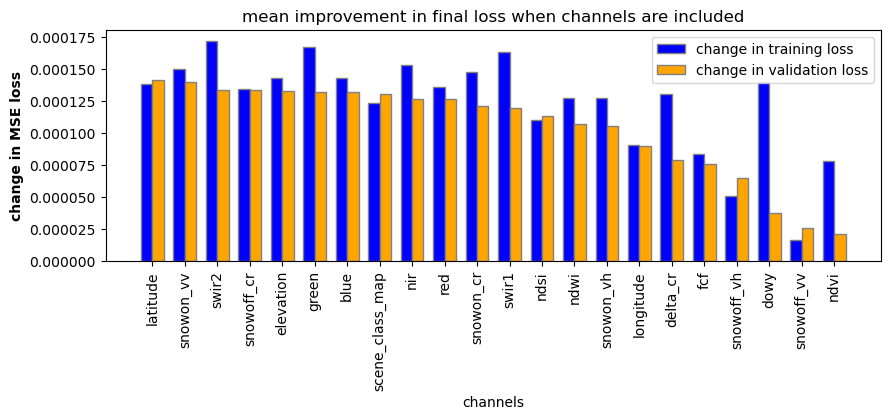

In [35]:
# Set the position of the bars on the x-axis
bar_width = 0.35
r1 = np.arange(len(df['channels']))
r2 = [x + bar_width for x in r1]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(r1, df['train_loss_diff'], color='blue', width=bar_width, edgecolor='grey', label='change in training loss')
ax.bar(r2, df['val_loss_diff'], color='orange', width=bar_width, edgecolor='grey', label='change in validation loss')
# Add labels
ax.set_xlabel('channels')
ax.set_xticks([r + bar_width/2 for r in range(len(df['channels']))])
ax.set_xticklabels(df['channels'], rotation=90)
ax.set_ylabel('change in MSE loss', fontweight='bold')
ax.set_title('mean improvement in final loss when channels are included')
# Add legend
ax.legend()